# Analyse des données textuelles

À partir des données l'application [Yelp](https://www.yelp.fr), traiter les sujets d'insatisfaction dans les commentaires client.

**Analyser les commentaires pour détecter les différents sujets d’insatisfaction**
 - pré-traitement des données textuelles
 - utilisation de techniques de réduction de dimension
 - visualisation des données de grandes dimensions

**Collecter un échantillon (environ 200 restaurants) de données via l’API Yelp**
 - récupérer uniquement les champs nécessaires
 - stocker les résultats dans un fichier exploitable (par exemple csv)
 
Cette deuxième partie concerne le modèle **Latent Dirichlet Allocation** afin de trouver le nombre et le genre des sujets d'insatisfaction.


## Latent Dirichlet Allocation

Le Latent Dirichlet Allocation est un modèle probabiliste génératif de corpus.
Cela consiste à considérer les documents comme des mélanges aléatoires sur des topics sous-jacents, où chaque topic est caractérisé par une une distribution sur les mots.

Nous allons calculer le score de cohérence pour les différents nombres de topics afin de choisir celui qui convient le mieux. Le nombre de topics optimal selon cette mesure correspond au moins grand nombre de topics avant que le score de cohérence ne se mette à baisser.

# Chargement des bibliothèques

In [59]:
import numpy as pd
import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim import models
from gensim.models import CoherenceModel

from sklearn.feature_extraction.text import TfidfVectorizer

import pyLDAvis
import pyLDAvis.gensim

from pprint import pprint

import matplotlib.pyplot as plt
%matplotlib inline

import pickle
from IPython.display import Markdown, Latex

In [60]:
# Nécessaire lors de la phase de développement pour mettre à jour les classes externes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [62]:
data_dir = '../data/'

# Entrainement du modèle

In [63]:
def tokenize(sentences):    
    data = []
    for sentence in list(sentences):
        data.append(sentence.split(" "))
    return data

In [161]:
def create_dict_tf_idf(dataset):
    
    
     # Création du dictionnaire
    dictionary = corpora.Dictionary(dataset)
    corpus = [dictionary.doc2bow(line) for line in dataset]  
    model = models.TfidfModel(corpus)
    
    return dictionary, corpus, model
    #tfidf = models.TfidfModel(data, id2word, normalize=False)

    # Création du corpus
    #corpus = [id2word.doc2bow(text) for text in data]
    
    #tfidf = models.TfidfModel(data, corpus)
    #corpus_tfidf = tfidf[corpus]

    #return id2word, corpus_tfidf

In [162]:
def train_model(num_topics, corpus, dictionary):
    chunksize = 2000
    passes = 1
    iterations = 100
    eval_every = 1
    
    model = gensim.models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            chunksize=chunksize,
            alpha='auto',
            eta='auto',
            iterations=iterations,
            num_topics=num_topics,
            passes=passes,
            eval_every=eval_every,
            random_state=63            
            )
    return model

## Chargement des données précédement traitées
On créé 2 dataframe un avec 10 commentaires qui servira à vérifier la segmenttaion et l'autre servant à l'entrainement du modèle.

In [163]:
df = pd.read_csv(data_dir + 'train_reviews.csv')
test = pd.read_csv(data_dir + 'test_reviews.csv')
df.head()

,Unnamed: 0,text,stars,clean_text,bad_review
0,306484,Always start with something nice is what I say...,1,always start nice say decoration building real...,1
1,522089,Ehhh.... cool that we have a taco spot in the ...,2,ehhh cool taco spot neighborhood good thing fr...,1
2,1120613,"The food I will give a 5, but the service toni...",1,food give service tonight downstairs exception...,1
3,632782,Flan tastes like store bought Pernil tasted ol...,1,flan taste store buy pernil taste old arroz co...,1
4,135142,"Damn, is it just me or is it feeling a little ...",2,damn feel little shilly new itp bbq place form...,1


## Création du corpus
Nous allons créer un dictionnaire avec les mots de chaque commentaire. Nous avons utilisé l'algorithme de TF-IDF pour pondérer les mots les plus fréquents dans l'ensemble des documents.

In [164]:
# Tokenization
data = tokenize(df['clean_text'])
dictionary, corpus, tfidf  = create_dict_tf_idf(data)
print(f"{len(dictionary)} mots uniques dans {len(corpus)} commentaires")

42817 mots uniques dans 60000 commentaires


## Recherche du nombre de topics
Pour la recherche du nombre optimale de topics, nous allons utiliser le score de cohérence. Le score de cohérence est pour un sujet, les mots qui ont la plus forte probabilité de se produire pour ce sujet.

Le nombre de topics optimal selon cette mesure correspond au moins grand nombre de topics avant que le score de cohérence ne se mette à baisser.

En fonction du score de cohérence on peut évaluer la solidité du modèle

|Score|Interprétation|
| ---- | :---------------- |
|0.3|mauvais|
|0.4|faible|
|**0.55**|**correct**|
|**0.65**|**normal**|
|**0.7**|**bien**|
|0.8|peu probable|
|0.9 |probablement faux|


In [142]:
start = 2
limit = 20
step = 3

In [143]:
coherence_values = []

for num_topics in range(start, limit, step):
    model = train_model(num_topics,corpus, dictionary)
    coherence_model = CoherenceModel(model=model, texts=data, dictionary=dictionary, coherence='c_v')
    coherence_value = coherence_model.get_coherence()
    coherence_values.append(coherence_value)
    print(f"{num_topics} topics avec un score de cohérence de {coherence_value:.4f}")

/home/psa/.local/lib/python3.8/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/home/psa/.local/lib/python3.8/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


2 topics avec un score de cohérence de nan
5 topics avec un score de cohérence de nan
8 topics avec un score de cohérence de nan
11 topics avec un score de cohérence de nan
14 topics avec un score de cohérence de nan
17 topics avec un score de cohérence de nan


## Visualisation de la cohérence

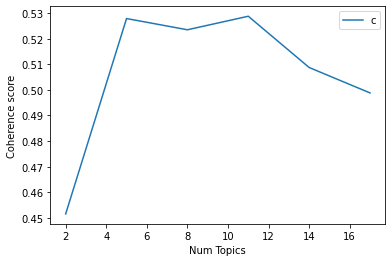

In [70]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Sélection du nombre de topics
D'après le modèle LDA le nombre de topic optimal est 8.

Nous allons tenter d'expliquer les topics trouvés avec les mots clés qui ont été classés.

In [152]:
num_topics = 8

In [153]:
model = train_model(num_topics, corpus, dictionary)

# Explication des topics

In [154]:
topics = {}
x = range(start, limit, step)
pprint(model.print_topics(num_topics, 5))
for topic in model.print_topics(num_topics, 5):
    topics[topic[0]] = topic[1]  

[(0,
  '0.005*"food" + 0.005*"good" + 0.004*"place" + 0.004*"chicken" + '
  '0.004*"order"'),
 (1,
  '0.006*"bouncer" + 0.005*"tikka" + 0.004*"cheesesteak" + 0.003*"german" + '
  '0.003*"robin"'),
 (2,
  '0.008*"table" + 0.007*"wait" + 0.006*"minute" + 0.006*"customer" + '
  '0.005*"bar"'),
 (3,
  '0.007*"doughnut" + 0.005*"boba" + 0.004*"mole" + 0.004*"doordash" + '
  '0.003*"zucchini"'),
 (4,
  '0.005*"estimate" + 0.004*"shawarma" + 0.004*"dominos" + 0.004*"ghetto" + '
  '0.004*"renovation"'),
 (5,
  '0.007*"strawberry" + 0.005*"omelet" + 0.005*"sangria" + 0.004*"squeeze" + '
  '0.004*"lounge"'),
 (6,
  '0.007*"crawfish" + 0.003*"pok" + 0.002*"discriminate" + 0.002*"tacos" + '
  '0.002*"amy"'),
 (7,
  '0.007*"order" + 0.007*"hour" + 0.007*"call" + 0.006*"minute" + '
  '0.006*"wait"')]


 - Groupe 0 : 
 - Groupe 1 : 
 - Groupe 2 : 
 - Groupe 3 : 
 - Groupe 4 : 
 - Groupe 5 : 
 - Groupe 6 :
 - Groupe 7 :
 - Groupe 8 :

# Visualisation des topcis

In [138]:
pyLDAvis.enable_notebook()
p_lda = pyLDAvis.gensim.prepare(model, corpus, dictionary)
pyLDAvis.save_html(p_lda, 'lda.html')
p_lda

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.426671 -0.057202       1        1  53.460742
0     -0.392548 -0.036019       2        1  31.262877
2     -0.065429  0.281625       3        1   5.312879
5      0.091913 -0.053899       4        1   2.673131
3      0.110819 -0.034057       5        1   1.587990
9      0.109826 -0.024663       6        1   1.276146
8      0.114156 -0.023942       7        1   1.199215
10     0.115419 -0.021769       8        1   1.175236
1      0.114934 -0.012717       9        1   0.795345
4      0.113481 -0.008616      10        1   0.638198
6      0.114100 -0.008741      11        1   0.618241, topic_info=         Term         Freq        Total Category  logprob  loglift
71    chicken   855.000000   855.000000  Default  30.0000  30.0000
160     taste   764.000000   764.000000  Default  29.0000  29.0000
84      sauce   552.000000   552.000000  Default  28.0000  28.0000
185    cheese   536.000000   536.000000  Default  27.0000  27.0000
62       wait  1088.000000  1088.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
6955      fav     3.865198     4.567457  Topic11  -6.2515   4.9191
7328  boycott     3.774456     4.477270  Topic11  -6.2753   4.9153
2714    abuse     3.765557     4.469993  Topic11  -6.2777   4.9146
2902   smoker     3.706239     4.410029  Topic11  -6.2935   4.9122
7431    tight     4.486749     5.408394  Topic11  -6.1024   4.8992

[530 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3280     10  0.799059    ability
2714     11  0.894856      abuse
2670      5  0.179071     accept
2670      6  0.752100     accept
2670      8  0.071629     accept
...     ...       ...        ...
8341     10  0.911521    working
5820      5  0.935811      worst
7083      9  0.949953      wound
1594      1  0.993575       yell
2296      1  0.988942  yesterday

[781 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 1, 3, 6, 4, 10, 9, 11, 2, 5, 7])

# Prédictions

## Prédiction avec des données de test

In [155]:
for index, row in test.iterrows():
    data = tokenize([row['clean_text']])
    new_vec = dictionary.doc2bow(data[0])
    pred = model[new_vec]    
    topic = max(pred, key=lambda item: item[1])[0]
    print(pred)
    print(topic)
    #display(Markdown(f"**Topic {topic} - {topics[topic]}**"))
    display(Markdown(f"> {row['text']}"))


[(0, 0.5573198), (2, 0.3080183), (7, 0.13131814)]
0


> Excellent food and ambiance. Really impressed with the newly added raw bar, oysters and ceviche were top notch, charcuterie did not disappoint. Wonderful cheeses and fresh meats.  My disappointment sadly comes from the service. Our waitress was friendly and apologetic for the delays but on a Saturday night, it appears as she was literally the only server for 6-8 tables. A little mind boggling that she did not have any help for presumably the entire dining room. It really took away from the overall experience. As good as the food was, waiting 15-20 minutes for our first round, another 20 for the apps, and shockingly another 25 for the charcuterie leaves a bit of a sour taste. It's unfortunate as the food and wine was on point and A+, I just can't imagine why they leave the entire dining area to one waitress for all the tables. A sign of poor management and lack of planning for sure, I just don't know if I can return as the prices you pay are a little steep for absentee service. Again the waitress was polite and informative, just disappointing how understaffed the place was. Moody's- here's an idea, maybe have... gasp... 2? Waitresses for entire floor and you wouldn't have people who love the food but get understandably annoyed waiting 30 min for apps and a refil on an empty wine glass. I'm literally waiting to rack up a bill but there's only so many hours in a day........

[(0, 0.4086074), (2, 0.25098082), (4, 0.054017425), (7, 0.28072342)]
0


> The ticket said that vip had to be on the dock to board at 10:15... after torrential downpours we boarded at 11:15... left at 12:15 and came back 45 min late @ 2:45. They don't tell you to bring 3$ if you want food (no card). Drinks are an average of 15$ after the ticket price. Mind you we paid extra for merchandise that was never given out to ANY vip person. We could have saved 50$ by purchasing general admission AND gotten the same deal. If you like getting ripped off... go on this boat ride. The girl next to us got the same deal for 10$.... my girl and I paid 50$ for the same ticket... we could have brought a crew for that price. RIP OFF

[(0, 0.5847206), (2, 0.35442048), (7, 0.051659085)]
0


> This was the worst experience at Conan's thus far and we've been coming here quite a bit over the years. No white crust just wheat and bad service. The young guy at the register definitely needed some customer service training. Sounded fed up for the day and didn't care much. Sorry but it wasn't our fault. We walked out and enjoyed a great dinner elsewhere. Hope his attitude improves. Happy New Year!

[(0, 0.61684483), (2, 0.13693342), (5, 0.023304373), (7, 0.21985795)]
0


> Haven't been here in over a year due to bad customer service,, so we thought we would try it again. Our waitress was very polite, but slow. We had to wait for a while for our drinks. My mom did not like her drink so she ordered wine and they never offered to take the first drink off the bill. When I asked for a little extra dressing for my salad, because it was a little dry, they charged me. I asked for the manager and he explained that all restaurants do this now, but we eat out all the time and have never been charged! The food was good and the portions were substantial, but the customer service wasn't there. I even had to use a teaspoon for my soup because they did not have any soup spoons and soup is always on the menu. They seem to have a big turnover in staff here. The manager said he would take the additional charge off for the dressing because he did not want to lose a customer. Got the 50 cents back, but that will not bring us back. There are too many other nicer restaurants  to go to with better service. We will not go back, the 50 cents did not keep these customers that used to go weekly.

[(0, 0.7881167), (2, 0.08549879), (7, 0.11189165)]
0


> Had a takeout today...very disappointed. Sorry Red curry. Chicken had a weird smell..,that gives me question if the chicken are fresh here of frozen or expired. I will give you another chance next time...i will update my review again...soon hopefully.

[(0, 0.62485296), (2, 0.28252447), (7, 0.0802891)]
0


> So, I'll start with the positive. Le Bistro Montage has a really cool space tucked away in the east side industrial district underneath the Morrison bridge. It does get packed for brunch but has seating at the counter. I was eager to try it out for a weekend brunch and love Cajun cuisine. However, it has to be the worst dining experience I've had in Portland, by far.   I opted for the counter to avoid a long wait. From our first interaction with our server, it felt like one of those bizarro world experiences where your service is so bad that you question whether you offended them personally.  We mounted a charm offensive, but to no avail. Since I was at the counter, I could see she forgot to enter in our order for some time.   After a punishingly long wait for our food, which arrived over 20 min later than the couple next to me who were seated at the same time, I was served some very sad overcooked eggs in what was supposed to be the Cajun scramble along with a joyless dry biscuit and stale potatoes. It might have been that they sat under a heat lamp too long, per aforementioned service.There was a heavy taste of vinegar over the whole dish rendering it pretty unpleasant. A great meal in a cool space might have carried me past the service. But it wasn't and it didn't, I'll never get that hour of my life back.

[(0, 0.7595677), (2, 0.14745721), (7, 0.082567826)]
0


> What's going on with their King crab-legs?  I've ordered them twice during recent visits and both times they were inedibly salty.  Not sure their issue. The very first time I had them they were sweet and fresh tasting but lately; they've been extremely salty.  The gumbo was bland.   Tried the Pappardelle pasta as a side option and it was amazing  How are they able to master pasta and not seafood? ‍.

[(0, 0.3571614), (2, 0.43611556), (7, 0.18737328)]
2


> The food itself is 5 stars but that doesn't help the 20 mins waiting for the waitress to take our orders and once she took our orders she became extremely rude and brushed us off as we were ordering

[(0, 0.8837272), (2, 0.061500985), (7, 0.042484704)]
0


> I came here because it had 4 stars so I figured I couldn't go wrong. People recommended the cold brew so I decided to try it. It was the worst coffee I've ever tried and I try coffee everywhere. I also bought a bread pudding as it looked and sounded good. Once again terribly disappointed.

[(0, 0.54531187), (2, 0.28832132), (7, 0.14242122)]
0


> The placed smelled like a combination of dirty feet, and the bathroom after a night of beer, chili and jalapeno poppers

## Prédiction avec de nouvelles données en provenance de l'API Yelp

## Chargement des données

In [55]:
new_df = pd.read_csv(data_dir + 'london_sample.csv')

## Prédictions

In [56]:
for index, row in new_df.iterrows():
    data = tokenize(row['clean_text'])
    new_vec = dictionary.doc2bow([str(data)])
    pred = model[new_vec]    
    topic = max(pred, key=lambda item: item[1])[0]
    display(Markdown(f"**Topic {topic} - {topics[topic]}**"))
    display(Markdown(f"> {row['text']}"))


**Topic 7 - 0.006*"wait" + 0.006*"order" + 0.006*"service" + 0.006*"minute" + 0.005*"time"**

> Terrible service from the time I sat down. Had to flag down multiple people other than our actual waitress whom was nowhere to be found in order to order...

**Topic 7 - 0.006*"wait" + 0.006*"order" + 0.006*"service" + 0.006*"minute" + 0.005*"time"**

> If you like Burned Pizza and Bad Service that is the place for you. We ordered a pizza to go and the pizza was soggy, soft and very burned under the...

**Topic 7 - 0.006*"wait" + 0.006*"order" + 0.006*"service" + 0.006*"minute" + 0.005*"time"**

> We were frequent visitors of Vapiano's when we lived in Vienna, so we know what to expect, and I have to say their food and service were always...

**Topic 7 - 0.006*"wait" + 0.006*"order" + 0.006*"service" + 0.006*"minute" + 0.005*"time"**

> Walked in for dinner. First night in London and super excited for meat & ale pie. Sat at a table upstairs. 10 minutes went by and no one came around at all....